# Noise and Outliers Simulation
## Objective

This notebook demonstrates how noise and outliers:

- Distort statistical estimates

- Bias machine learning models

- Break assumptions of common algorithms

- Lead to unstable and non-robust predictions

We simulate __multiple noise regimes and outlier mechanisms__, evaluate their impact, and apply robust mitigation strategies.

## Why Noise and Outliers Matter

In real business data:

- Measurement errors exist

- Fraud and rare events occur

- Data pipelines introduce inconsistencies

- Extreme values often carry business meaning

Blind removal is often __incorrect__. Controlled handling is essential.

## Imports and Configuration

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

RANDOM_STATE = 2010
np.random.seed(RANDOM_STATE)


## Step 1 – Generate a Clean Regression Dataset

In [3]:
N_SAMPLES = 5000

x1 = np.random.normal(50, 10, size=N_SAMPLES)
x2 = np.random.normal(100, 20, size=N_SAMPLES)

y = (
    3.5 * x1
    + 1.8 * x2
    + np.random.normal(0, 15, size=N_SAMPLES)
)

df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "target": y
})

df.describe()


,x1,x2,target
count,5000.000000,5000.000000,5000.000000
mean,50.056019,99.802522,354.998902
std,9.964798,20.208742,52.442556
min,17.587327,21.551995,161.695867
25%,43.420950,86.268342,320.285784
50%,50.134656,99.650989,353.963643
75%,56.660106,113.544761,390.516611
max,89.262377,170.581104,547.090428


# Step 2 – Baseline Model Performance (No Noise Injection)

In [5]:
X = df[["x1", "x2"]]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE
                                                   )

baseline_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                                    ("model", LinearRegression()
                                    )]
                            )

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

print("Baseline MAE:", mean_absolute_error(y_test, y_pred))
print("Baseline RMSE:", mean_squared_error(y_test, y_pred, squared=False))


Baseline MAE: 12.120947770693512
Baseline RMSE: 15.166304425498435


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visualization (No outliers)

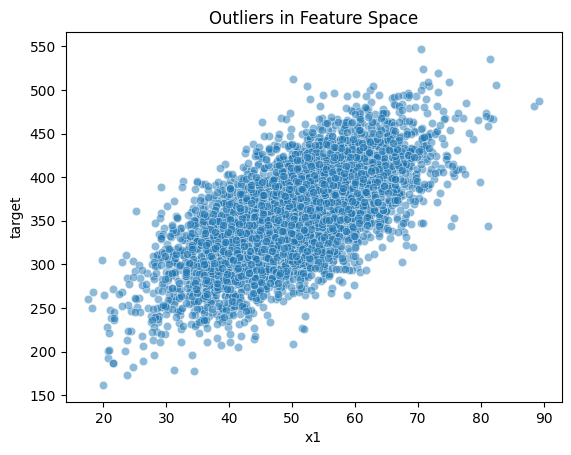

In [26]:
plt.figure()
sns.scatterplot(data=df, x="x1", y="target", alpha=0.5)
plt.title("No outliers in Feature Space")
plt.show()


# Step 3 – Add Gaussian Noise (Measurement Error)
## Simulation

In [6]:
df_gaussian_noise = df.copy()

df_gaussian_noise["x1"] += np.random.normal(0, 20, size=N_SAMPLES)
df_gaussian_noise["x2"] += np.random.normal(0, 30, size=N_SAMPLES)


## Evaluation

In [7]:
X = df_gaussian_noise[["x1", "x2"]]
y = df_gaussian_noise["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

print("Gaussian Noise MAE:", mean_absolute_error(y_test, y_pred))
print("Gaussian Noise RMSE:", mean_squared_error(y_test, y_pred, squared=False))


Gaussian Noise MAE: 36.52906605682489
Gaussian Noise RMSE: 45.96742476299286


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Insight

 - Linear models degrade gracefully under symmetric noise

 - Signal-to-noise ratio is critical

# Step 4 – Inject Random Outliers (Rare Extreme Values)
## Simulation

In [8]:
df_outliers = df.copy()

outlier_fraction = 0.03
n_outliers = int(N_SAMPLES * outlier_fraction)

outlier_idx = np.random.choice(df.index, n_outliers, replace=False)

df_outliers.loc[outlier_idx, "x1"] *= 5
df_outliers.loc[outlier_idx, "x2"] *= 6
df_outliers.loc[outlier_idx, "target"] *= 4


## Visualization

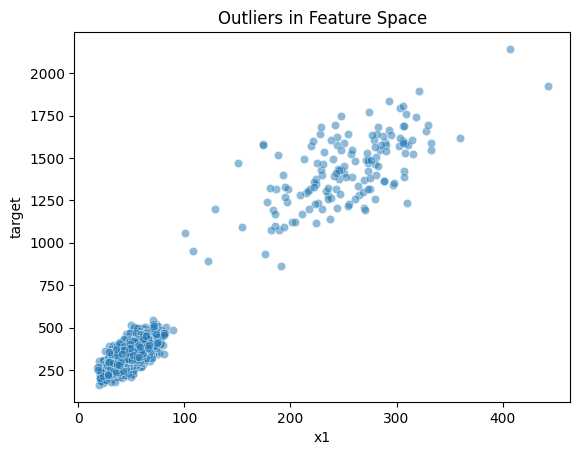

In [25]:
plt.figure()
sns.scatterplot(data=df_outliers, x="x1", y="target", alpha=0.5)
plt.title("Outliers in Feature Space")
plt.show()


## Evaluation with Linear Regression

In [10]:
X = df_outliers[["x1", "x2"]]
y = df_outliers["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

print("Outliers MAE (Linear):", mean_absolute_error(y_test, y_pred))
print("Outliers RMSE (Linear):", mean_squared_error(y_test, y_pred, squared=False))


Outliers MAE (Linear): 18.579753010520367
Outliers RMSE (Linear): 23.868225912374864


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Step 5 – Robust Regression (Huber Loss)

In [11]:
robust_pipeline = Pipeline(
    steps=[
        ("scaler", RobustScaler()),
        ("model", HuberRegressor())
    ]
)

robust_pipeline.fit(X_train, y_train)
y_pred = robust_pipeline.predict(X_test)

print("Outliers MAE (Huber):", mean_absolute_error(y_test, y_pred))
print("Outliers RMSE (Huber):", mean_squared_error(y_test, y_pred, squared=False))


Outliers MAE (Huber): 18.188786328088558
Outliers RMSE (Huber): 23.779759297330994


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Insight

- Robust estimators reduce sensitivity to extreme observations without discarding data.


# Step 6 – Tree-Based Model Robustness

In [12]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Outliers MAE (Random Forest):", mean_absolute_error(y_test, y_pred))
print("Outliers RMSE (Random Forest):", mean_squared_error(y_test, y_pred, squared=False))


Outliers MAE (Random Forest): 14.618021887136019
Outliers RMSE (Random Forest): 22.13148174178979


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Insight

Tree-based models:

- Are naturally robust to monotonic transformations

- Still degrade under extreme target outliers

# Step 7 – Leverage Points vs Vertical Outliers
## Simulation

In [13]:
df_leverage = df.copy()

leverage_idx = np.random.choice(df.index, 40, replace=False)

df_leverage.loc[leverage_idx, "x1"] = 400
df_leverage.loc[leverage_idx, "x2"] = 600


## Visualization

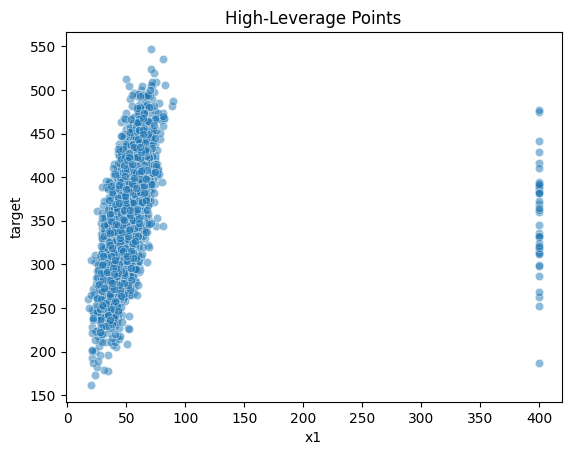

In [24]:
plt.figure()
sns.scatterplot(data=df_leverage, x="x1", y="target", alpha=0.5)
plt.title("High-Leverage Points")
plt.show()

## Evaluation

In [15]:
X = df_leverage[["x1", "x2"]]
y = df_leverage["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

print("Leverage MAE (Linear):", mean_absolute_error(y_test, y_pred))


Leverage MAE (Linear): 38.85442903941262


## Key Insight

Leverage points are more dangerous than vertical outliers for linear models.

# Step 8 – Outlier Treatment Strategies
## Winsorization

In [16]:
df_winsor = df_outliers.copy()

for col in ["x1", "x2", "target"]:
    lower = df_winsor[col].quantile(0.01)
    upper = df_winsor[col].quantile(0.99)
    df_winsor[col] = df_winsor[col].clip(lower, upper)


## Visualization

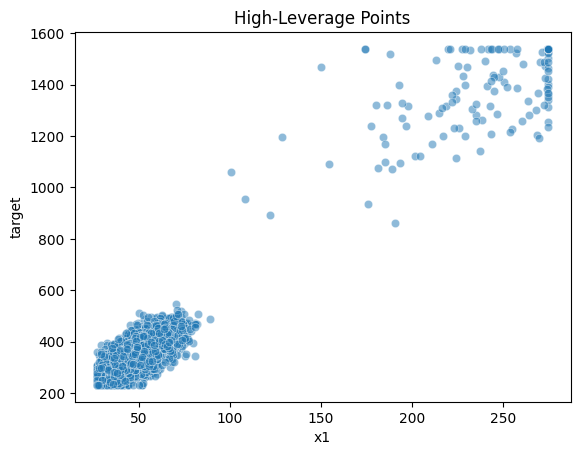

In [19]:
plt.figure()
sns.scatterplot(data=df_winsor, x="x1", y="target", alpha=0.5)
plt.title("High-Leverage Points")
plt.show()

In [18]:
X = df_winsor[["x1", "x2"]]
y = df_winsor["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

print("Winsor MAE (Linear):", mean_absolute_error(y_test, y_pred))

Winsor MAE (Linear): 18.281554854376807


## Robust Scaling

Already demonstrated using RobustScaler.

## Model Choice

Tree-based or robust-loss models when:

- Outliers are expected

- Business meaning exists

# Step 9 – Business Interpretation


| Scenario                | Risk               |
| ----------------------- | ------------------ |
| Ignoring noise          | Underfitting       |
| Removing all outliers   | Losing signal      |
| Linear model + leverage | Model collapse     |
| Robust methods          | Controlled bias    |
| Trees without checks    | Silent degradation |


## Summary

This notebook demonstrated:

- Different noise mechanisms

- Random vs structured outliers

- Leverage point risk

- Model sensitivity differences

- Robust mitigation strategies

__Noise and outliers are not bugs — they are features of reality.__